Configure.

In [2]:
# TRAINING SETTINGS
NUM_EPOCHS = 8


# LEARNING RATE SETTINGS
BASE_LR = 0.001
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 8 # set the number of classes in your dataset
DATA_DIR = '/shared/home/jea040/Final_Project/data'


# DATALOADER PROPERTIES
BATCH_SIZE = 32


# GPU SETTINGS
CUDA_DEVICE = 0 # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
GPU_MODE = 1 # set to 1 if want to run on gpu.

Import all packages.

In [3]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import time
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the NIH Dataset using the labels that overlap between the two datasets.

In [8]:
# Define the unified label set (including "Normal")
UNIFIED_LABELS = [
    "atelectasis", "cardiomegaly", "pleural effusion", "infiltration", 
    "nodule", "consolidation", "pleural thickening", "no finding"
]

# Define the mapping for "Finding Labels" to the unified labels
LABEL_MAP_NIH = {
    "atelectasis": 0,
    "cardiomegaly": 1,
    "effusion": 2,
    "infiltration": 3,
    "nodule": 4,
    "consolidation": 5,
    "pleural_thickening": 6,
    "no finding": 7
}

In [9]:
class NIHChestXrayDataset(Dataset):
    def __init__(self, images_dir, labels_csv, split_file=None, transform=None):
        self.images_dir = images_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.split_file = split_file
        self.transform = transform
    
        # Filter CSV to match split list BEFORE generating label dict
        if self.split_file:
            with open(self.split_file, 'r') as f:
                keep_files = set(line.strip() for line in f.readlines())
            self.labels_df = self.labels_df[self.labels_df['Image Index'].isin(keep_files)]
    
        # Now build image label dict using the filtered DataFrame
        self.image_label_dict = self._get_image_labels()
        self.image_filenames = list(self.image_label_dict.keys())


    def _get_image_labels(self, max_no_finding=5000):
        image_label_dict = {}
        no_finding_count = 0
    
        for index, row in self.labels_df.iterrows():
            image_filename = row['Image Index']
            label_vector = torch.zeros(len(UNIFIED_LABELS))
            finding_labels = row['Finding Labels'].split('|')
            finding_labels = [label.strip().lower() for label in finding_labels]
    
            # Skip if none of the labels are in UNIFIED_LABELS
            valid_labels = [label for label in finding_labels if label in LABEL_MAP_NIH]
            if not valid_labels:
                continue
    
            # Check if it's a no finding image
            is_no_finding = (valid_labels == ['no finding'])
    
            if is_no_finding:
                if no_finding_count >= max_no_finding:
                    continue
                no_finding_count += 1
                label_vector[LABEL_MAP_NIH['no finding']] = 1
            else:
                for label in valid_labels:
                    label_vector[LABEL_MAP_NIH[label]] = 1
    
            image_label_dict[image_filename] = label_vector
    
        print(f"Total valid images (after downsampling): {len(image_label_dict)}")
        return image_label_dict

    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        
        # Construct the image path
        image_path = os.path.join(self.images_dir, image_filename)
        
        # Skip if the image does not exist
        if not os.path.exists(image_path):  # If image is missing
            return None  # Return None if image is missing
        
        try:
            image = Image.open(image_path).convert('RGB')  # Open image
        except Exception:
            return None  # Skip if image cannot be opened (e.g., corrupted)
        
        # Get the label vector for the image
        label_vector = self.image_label_dict.get(image_filename, torch.zeros(len(UNIFIED_LABELS)))
        
        # Apply transformations if available
        if self.transform:
            image = self.transform(image)
        
        return image, label_vector

In [10]:
# Load DataFrame
df = pd.read_csv("/shared/home/jea040/Final_Project/data/NIH_chestxrays/Data_Entry_2017.csv")

# Restrict to images listed in split file (if desired)
with open("/shared/home/jea040/Final_Project/data/NIH_chestxrays/train_val_list.txt", "r") as f:
    keep_images = set(line.strip() for line in f)

df = df[df['Image Index'].isin(keep_images)]

# Unified labels and lowercase set for matching
valid_labels = set(label.lower() for label in UNIFIED_LABELS)

# Per-label count and total valid image counter
counts = {label: 0 for label in UNIFIED_LABELS}
valid_image_count = 0

# Iterate over rows
for _, row in df.iterrows():
    labels = [label.strip().lower() for label in row['Finding Labels'].split('|')]

    # Only count if image has at least one label in our set
    if any(label in valid_labels for label in labels):
        valid_image_count += 1
        for label in labels:
            if label in counts:
                counts[label] += 1

# Output
print(f"Total valid images: {valid_image_count}")
for label in UNIFIED_LABELS:
    print(f"{label}: {counts[label]}")


Total valid images: 76400
atelectasis: 8280
cardiomegaly: 1707
pleural effusion: 0
infiltration: 13782
nodule: 4708
consolidation: 2852
pleural thickening: 0
no finding: 50500


We can see that 'no finding' is very overrepresented. so I implemented a max feature and that prevents too many no findings.

In [11]:
from collections import Counter
import torch

# Define transformations for train and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
}

# Paths to your datasets
nih_images_dir = '/shared/home/jea040/Final_Project/data/NIH_chestxrays/images'  # Path to NIH images
nih_labels_csv = '/shared/home/jea040/Final_Project/data/NIH_chestxrays/Data_Entry_2017.csv'  # NIH CSV file

# Dataset instances
train_dataset = NIHChestXrayDataset(images_dir=nih_images_dir, labels_csv=nih_labels_csv, transform=data_transforms['train'])

label_counts = torch.zeros(len(UNIFIED_LABELS), dtype=torch.int32)

for label_vector in train_dataset.image_label_dict.values():
    label_counts += label_vector.int()

# Print results
for label, count in zip(UNIFIED_LABELS, label_counts):
    print(f"{label}: {count.item()}")


Total valid images (after downsampling): 48877
atelectasis: 11559
cardiomegaly: 2776
pleural effusion: 13317
infiltration: 19894
nodule: 6331
consolidation: 4667
pleural thickening: 3385
no finding: 5000


Print out samples to ensure that theyre being labeled correctly. Easy to cross check with the csv file.

In [7]:
for i in range(5):  # Check the first 5 images in the dataset
    sample_image, sample_label_vector = train_dataset[i]
    
    # Get the image filename (this comes from the image filenames in the dataset)
    image_filename = train_dataset.image_filenames[i]
    
    # Print the image filename and its corresponding label vector
    print(f"Image Filename: {image_filename}")
    print(f"Label Vector: {sample_label_vector}")


Image Filename: 00000001_000.png
Label Vector: tensor([0., 1., 0., 0., 0., 0., 0., 0.])
Image Filename: 00000001_001.png
Label Vector: tensor([0., 1., 0., 0., 0., 0., 0., 0.])
Image Filename: 00000001_002.png
Label Vector: tensor([0., 1., 1., 0., 0., 0., 0., 0.])
Image Filename: 00000002_000.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 00000003_003.png
Label Vector: tensor([0., 0., 0., 1., 0., 0., 0., 0.])


They're labeled correctly!!

Now let's define the PadChest dataset

In [12]:
# Define the unified label set (including "Normal")
UNIFIED_LABELS_pad = [
    "atelectasis", "cardiomegaly", "pleural effusion", "infiltration", 
    "nodule", "consolidation", "pleural thickening", "Normal"
]

# Define the mapping for "Finding Labels" to the unified labels
LABEL_MAP_pad = {
    "atelectasis": 0,
    "cardiomegaly": 1,
    "pleural effusion": 2,
    "infiltrates": 3,
    "nodule": 4,
    "consolidation": 5,
    "apical pleural thickening": 6,
    "pleural thickening": 6,
    "normal": 7
}

In [13]:
class PadChestDataset(Dataset):
    def __init__(self, images_dir, labels_csv, transform=None, max_normal=5000):
        self.images_dir = images_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform
        self.max_normal = max_normal
        
        # Map image filenames to labels (multi-labels as binary vectors)
        self.image_label_dict = self._get_image_labels()
        self.image_filenames = list(self.image_label_dict.keys())

    def _get_image_labels(self):
        image_label_dict = {}
        normal_count = 0

        for index, row in self.labels_df.iterrows():
            image_filename = row['ImageID']  # column with image name
            label_vector = torch.zeros(len(UNIFIED_LABELS_pad))
            finding_labels = row['label'].split('|')
            finding_labels = [label.strip().lower() for label in finding_labels]

            valid_labels = [label for label in finding_labels if label in LABEL_MAP_pad]

            # Skip if no valid labels
            if not valid_labels:
                continue

            # Check if this is a "Normal" image
            is_normal = (valid_labels == ['normal'])

            if is_normal:
                if normal_count >= self.max_normal:
                    continue
                normal_count += 1
                label_vector[LABEL_MAP_pad['normal']] = 1
            else:
                for label in valid_labels:
                    label_vector[LABEL_MAP_pad[label]] = 1

            image_label_dict[image_filename] = label_vector

        print(f"Total valid images (after downsampling): {len(image_label_dict)}")
        return image_label_dict

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.images_dir, image_filename)

        if not os.path.exists(image_path):
            return None
        
        try:
            image = Image.open(image_path).convert('RGB')
        except:
            return None
        
        label_vector = self.image_label_dict.get(image_filename, torch.zeros(len(UNIFIED_LABELS_pad)))
        
        if self.transform:
            image = self.transform(image)

        return image, label_vector


In [14]:
from collections import Counter
import torch

# Define transformations for train and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
}

# Paths to your datasets
padchest_images_dir = '/shared/home/jea040/Final_Project/data/padchest/images/PadChest_GR'  # Path to PadChest images
padchest_labels_csv = '/shared/home/jea040/Final_Project/data/padchest/master_table.csv'  # PadChest CSV file

padchest_dataset = PadChestDataset(images_dir=padchest_images_dir, labels_csv=padchest_labels_csv, transform=data_transforms['val'])

label_counts = torch.zeros(len(UNIFIED_LABELS), dtype=torch.int32)

for label_vector in padchest_dataset.image_label_dict.values():
    label_counts += label_vector.int()

# Print results
for label, count in zip(UNIFIED_LABELS, label_counts):
    print(f"{label}: {count.item()}")

# count unique images in csv file
df = pd.read_csv(padchest_labels_csv)
unique_image_count = df['ImageID'].nunique()  # or replace 'ImageDir' with the actual column name if different
print(f"\nTotal unique images in PadChest master_table.csv: {unique_image_count}")

Total valid images (after downsampling): 2519
atelectasis: 47
cardiomegaly: 455
pleural effusion: 147
infiltration: 126
nodule: 75
consolidation: 19
pleural thickening: 194
no finding: 1456

Total unique images in PadChest master_table.csv: 4555


In [20]:
for i in range(10):  # Check the first 5 images in the dataset
    sample_image, sample_label_vector = padchest_dataset[i]
    
    # Get the image filename (this comes from the image filenames in the dataset)
    image_filename = padchest_dataset.image_filenames[i]
    
    # Print the image filename and its corresponding label vector
    print(f"Image Filename: {image_filename}")
    print(f"Label Vector: {sample_label_vector}")

Image Filename: 100303250289824462365601716073337204998_42hmtt.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 100580687092336675079799190012948476945_luafr7.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 100617721005493358788622515939965631279_fgkwxw.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 100640384508558964776507219895956147931_71e4k0.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 100691470462906967644370330516500295793_x403rv.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 100823948745552785809672956317764747754_kmbl5u.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 100862492116707318754078191746182622275_obga4m.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 0., 1.])
Image Filename: 101120174235725780234709445792984239056_2oib6d.png
Label Vector: tensor([0., 0., 0., 0., 0., 0., 1., 0.])
Image Filename: 10112296

They map correctly!!

Now let's load in these datasets and define the transforms/training model:

In [15]:
# Define transformations for train and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
}

# Paths to your datasets
nih_images_dir = '/shared/home/jea040/Final_Project/data/NIH_chestxrays/images'  # Path to NIH images
padchest_images_dir = '/shared/home/jea040/Final_Project/data/padchest/images/PadChest_GR'  # Path to PadChest images
nih_labels_csv = '/shared/home/jea040/Final_Project/data/NIH_chestxrays/Data_Entry_2017.csv'  # NIH CSV file
padchest_labels_csv = '/shared/home/jea040/Final_Project/data/padchest/master_table.csv'  # PadChest CSV file

# Dataset instances
nih_dataset = NIHChestXrayDataset(images_dir=nih_images_dir, labels_csv=nih_labels_csv, transform=data_transforms['train'])
padchest_dataset = PadChestDataset(images_dir=padchest_images_dir, labels_csv=padchest_labels_csv, transform=data_transforms['val'])

# Split the full_train_dataset into training (80%) and validation (20%) datasets
train_size = int(0.8 * len(nih_dataset))
val_size = len(nih_dataset) - train_size

nih_train, nih_val = random_split(nih_dataset, [train_size, val_size])

# make sure that the it's using the right transforms
nih_train.dataset.transform = data_transforms['train']
nih_val.dataset.transform = data_transforms['val']

# DataLoaders for NIH (train) and PadChest (test)
train_loader = DataLoader(nih_train, batch_size=32, shuffle=True, num_workers=8)

val_loader = DataLoader(nih_val, batch_size=32, shuffle=False, num_workers=8)

valspanish_loader = DataLoader(pad_val, batch_size=32, shuffle=False, num_workers=8)

# Define the ResNet model
model_ft = models.resnet18(weights=False)  # Set pretrained=True if you want pretrained weights
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))  # Number of output labels

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Compute pos_weight using label counts
pos_counts = torch.tensor([11559, 2776, 13317, 19894, 6331, 4667, 3385, 5000], dtype=torch.float)
total = 48877
neg_counts = total - pos_counts
pos_weight = (neg_counts / pos_counts).to(device)

# Define the loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Define the learning rate scheduler function
def exp_lr_scheduler(optimizer, epoch, init_lr=0.0001, lr_decay_epoch=10):
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS, patience=3):
    since = time.time()
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_loss = float('inf')
    no_improve_epochs = 0
    printed_debug = False

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.sigmoid(outputs)
                    loss = criterion(outputs, labels)
                    preds = outputs > 0.5
                    running_corrects += (preds == labels).sum().item()
                    total_samples += labels.numel()

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        
                        if not printed_debug and epoch == 0:
                            print("Sample predictions (first 10):", preds[0].detach().cpu().numpy()[:10])
                            print("Sample labels (first 10):", labels[0].detach().cpu().numpy()[:10])
                            for name, param in model.named_parameters():
                                if param.grad is not None:
                                    print(f"{name} grad mean: {param.grad.abs().mean().item():.6f}")
                                    break
                            printed_debug = True

                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / total_samples
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in val loss for {patience} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    return best_model, accuracies, losses


Total valid images (after downsampling): 48877
Total valid images (after downsampling): 2519


/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Define test function.

In [ ]:
def evaluate_model(model, loader, criterion, phase_name="val"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            preds = outputs > 0.5
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.numel()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

    loss = running_loss / len(loader.dataset)
    acc = running_corrects / total_samples
    print(f"{phase_name} Loss: {loss:.4f}, Acc: {acc:.4f}")
    return loss, acc

Train non-pretrained model on train split of the NIH dataset. Validate on the val split of the NIH dataset.

In [19]:
# Run the training and testing phases
trained_model, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS, val=False)

# Save the model
torch.save(trained_model.state_dict(), 'nih_model.pt')

# Plot accuracy and loss for training and testing
epochs = range(NUM_EPOCHS)  # Using NUM_EPOCHS here for consistency


----------
Epoch 0/7
----------
Sample predictions (first 10): [False False False  True  True  True  True False]
Sample labels (first 10): [0. 0. 0. 0. 0. 0. 0. 1.]
conv1.weight grad mean: 0.005207
train Loss: 1.1283 Acc: 0.7753
val Loss: 1.1073 Acc: 0.7686
----------
Epoch 1/7
----------
train Loss: 1.1012 Acc: 0.7721
val Loss: 1.0859 Acc: 0.7736
----------
Epoch 2/7
----------
train Loss: 1.0873 Acc: 0.7748
val Loss: 1.0768 Acc: 0.7720
----------
Epoch 3/7
----------
train Loss: 1.0786 Acc: 0.7768
val Loss: 1.0797 Acc: 0.7739
----------
Epoch 4/7
----------
train Loss: 1.0706 Acc: 0.7819
val Loss: 1.0732 Acc: 0.7712
----------
Epoch 5/7
----------
train Loss: 1.0631 Acc: 0.7867
val Loss: 1.0678 Acc: 0.7574
----------
Epoch 6/7
----------
train Loss: 1.0553 Acc: 0.7916
val Loss: 1.0663 Acc: 0.7814
----------
Epoch 7/7
----------
train Loss: 1.0443 Acc: 0.8033
val Loss: 1.0671 Acc: 0.7780
Training complete in 19m 42s
Best val Acc: 0.7814


In [3]:
best_non_pretrained_acc = 0.7814

We should expect a consistent downward trend with loss and upwards with accuracy.

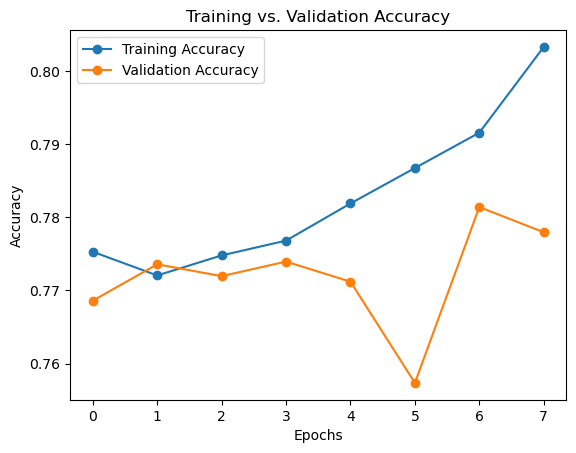

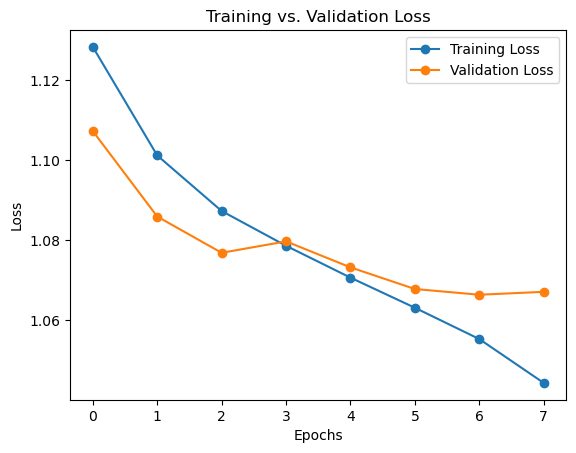

In [20]:
plt.plot(epochs, accuracies['train'], label="Training Accuracy", marker='o')
plt.plot(epochs, accuracies['val'], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, losses['train'], label="Training Loss", marker='o')
plt.plot(epochs, losses['val'], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()


Test non-pretrained model on PadChest dataset.

In [16]:
path = "/shared/home/jea040/Final_Project/notebooks/nih_model.pt"

# Step 1: Rebuild model architecture
model_ft = models.resnet18(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))  # update this if needed

# Step 2: Load weights
model_ft.load_state_dict(torch.load(path))

# Step 3: Move to device and evaluate
model_ft = model_ft.to(device)
model_ft.eval()

# Step 4: Evaluate
non_pretrained_losses, non_pretrained_accuracies = evaluate_model(model_ft, valspanish_loader, criterion)
print("Non-Pretrained model")
print(f"Loss: {non_pretrained_losses}")
print(f"Accuracy: {non_pretrained_accuracies}")

val Loss: 1.5466, Acc: 0.6417
Non-Pretrained model
Loss: 1.5466093279969384
Accuracy: 0.6416500994035785


Now with a pretrained model (transfer learning).

Now, train the pretrained ResNet18 model on the test split of the NIH dataset. Validate the model on the val split of the NIH dataset.

In [25]:
# change to pretrained = true
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))  # Number of output labels

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Compute pos_weight using label counts
pos_counts = torch.tensor([11559, 2776, 13317, 19894, 6331, 4667, 3385, 5000], dtype=torch.float)
total = 48877
neg_counts = total - pos_counts
pos_weight = (neg_counts / pos_counts).to(device)

# Define the loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Run the training and testing phases
trained_model, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS, val=False)

# Save the model
torch.save(trained_model.state_dict(), 'nih_model_pretrained.pt')

# Plot accuracy and loss for training and testing
epochs = range(NUM_EPOCHS)  # Using NUM_EPOCHS here for consistency

----------
Epoch 0/7
----------
Sample predictions (first 10): [ True  True False False False False False False]
Sample labels (first 10): [0. 0. 0. 1. 0. 0. 0. 0.]
conv1.weight grad mean: 0.002808
train Loss: 1.0814 Acc: 0.7782
val Loss: 1.0574 Acc: 0.7787
----------
Epoch 1/7
----------
train Loss: 1.0538 Acc: 0.7953
val Loss: 1.0503 Acc: 0.7885
----------
Epoch 2/7
----------
train Loss: 1.0361 Acc: 0.8094
val Loss: 1.0508 Acc: 0.7928
----------
Epoch 3/7
----------
train Loss: 1.0179 Acc: 0.8274
val Loss: 1.0481 Acc: 0.7903
----------
Epoch 4/7
----------
train Loss: 0.9962 Acc: 0.8480
val Loss: 1.0468 Acc: 0.8065
----------
Epoch 5/7
----------
train Loss: 0.9780 Acc: 0.8669
val Loss: 1.0474 Acc: 0.8175
----------
Epoch 6/7
----------
train Loss: 0.9607 Acc: 0.8841
val Loss: 1.0485 Acc: 0.8154
----------
Epoch 7/7
----------
train Loss: 0.9451 Acc: 0.8998
val Loss: 1.0503 Acc: 0.8244
Early stopping at epoch 7 due to no improvement in val loss for 3 epochs.
Training complete in 18m

In [4]:
best_pretrained_acc = 0.8244

We can see some overfitting.

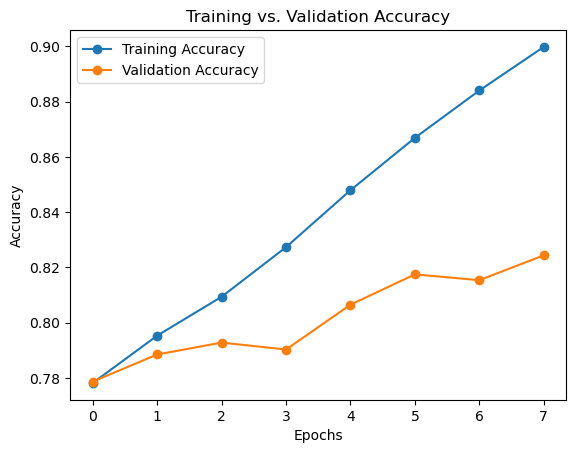

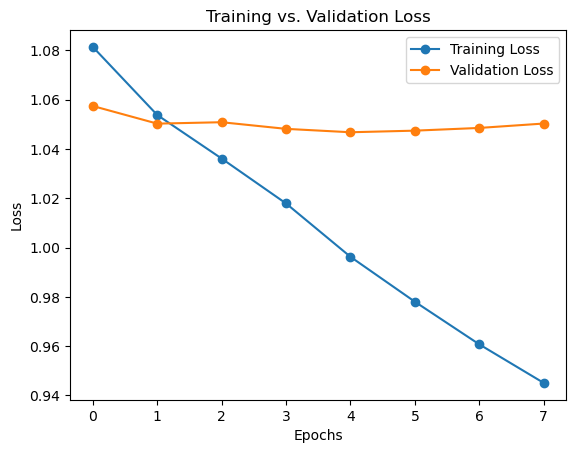

In [26]:
plt.plot(epochs, accuracies['train'], label="Training Accuracy", marker='o')
plt.plot(epochs, accuracies['val'], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, losses['train'], label="Training Loss", marker='o')
plt.plot(epochs, losses['val'], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

Test the pretrained model on the PadChest dataset.

In [17]:
path = "/shared/home/jea040/Final_Project/notebooks/nih_model_pretrained.pt"

# Step 1: Rebuild model architecture
model_ft = models.resnet18(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))  # update this if needed

# Step 2: Load weights
model_ft.load_state_dict(torch.load(path))

# Step 3: Move to device and evaluate
model_ft = model_ft.to(device)
model_ft.eval()

# Step 4: Evaluate
pretrained_losses, pretrained_accuracies = evaluate_model(model_ft, valspanish_loader, criterion)
print("Pretrained model")
print(f"Loss: {pretrained_losses}")
print(f"Accuracy: {pretrained_accuracies}")

val Loss: 1.5558, Acc: 0.6250
Pretrained model
Loss: 1.555759789455482
Accuracy: 0.625


Let's redefine the scheduler to work sooner to prevent overfitting!

In [28]:
# Define the quicker learning rate scheduler function
def quicker_exp_lr_scheduler(optimizer, epoch, init_lr=5e-5, lr_decay_epoch=3):
    lr = init_lr * (0.5**(epoch // lr_decay_epoch))  # decay slower and by factor of 0.5
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer


Train the pretrained model on the train split of the NIH dataset, but this time use the scheduler to prevent overfitting. Validate using the val split of the NIH dataset.

In [29]:
# reset variables
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))  # Number of output labels

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Compute pos_weight using label counts
pos_counts = torch.tensor([11559, 2776, 13317, 19894, 6331, 4667, 3385, 5000], dtype=torch.float)
total = 48877
neg_counts = total - pos_counts
pos_weight = (neg_counts / pos_counts).to(device)

# Define the loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)


# Run the training and testing phases
trained_model, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, quicker_exp_lr_scheduler, num_epochs=NUM_EPOCHS, val=False)

# Save the model
torch.save(trained_model.state_dict(), 'nih_model_pretrained_scheduled.pt')

# Plot accuracy and loss for training and testing
epochs = range(NUM_EPOCHS)  # Using NUM_EPOCHS here for consistency

----------
Epoch 0/7
----------
Sample predictions (first 10): [False False False False  True False  True False]
Sample labels (first 10): [0. 0. 1. 0. 0. 0. 0. 0.]
conv1.weight grad mean: 0.002143
train Loss: 1.0850 Acc: 0.7795
val Loss: 1.0585 Acc: 0.7769
----------
Epoch 1/7
----------
train Loss: 1.0489 Acc: 0.8038
val Loss: 1.0476 Acc: 0.7950
----------
Epoch 2/7
----------
train Loss: 1.0242 Acc: 0.8249
val Loss: 1.0447 Acc: 0.8092
----------
Epoch 3/7
----------
train Loss: 0.9884 Acc: 0.8612
val Loss: 1.0448 Acc: 0.8196
----------
Epoch 4/7
----------
train Loss: 0.9646 Acc: 0.8856
val Loss: 1.0497 Acc: 0.8264
----------
Epoch 5/7
----------
train Loss: 0.9447 Acc: 0.9046
val Loss: 1.0523 Acc: 0.8305
Early stopping at epoch 5 due to no improvement in val loss for 3 epochs.
Training complete in 14m 12s
Best val Acc: 0.8092


In [5]:
best_scheduled_pretrained_acc = 0.8305

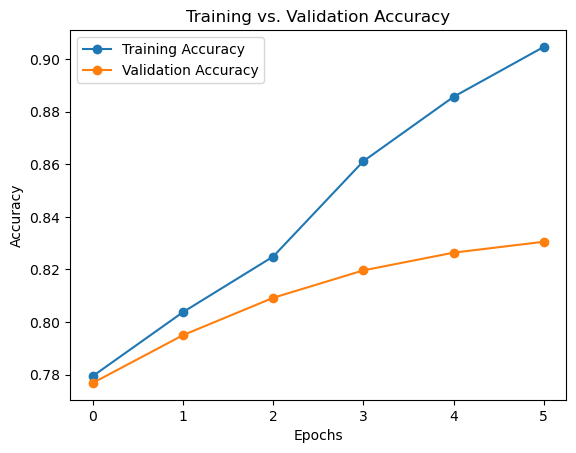

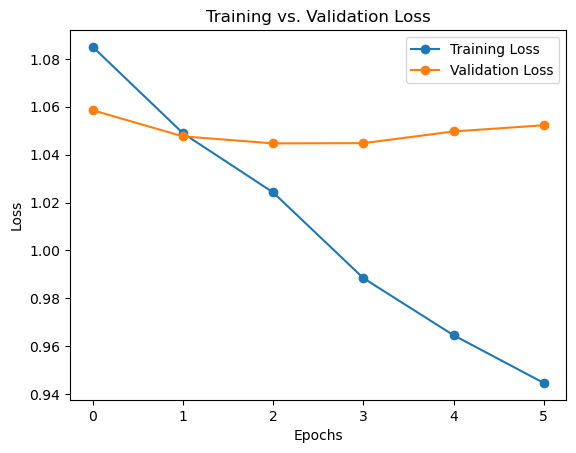

In [30]:
epochs = range(len(accuracies['train']))  # instead of NUM_EPOCHS

plt.plot(epochs, accuracies['train'], label="Training Accuracy", marker='o')
plt.plot(epochs, accuracies['val'], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, losses['train'], label="Training Loss", marker='o')
plt.plot(epochs, losses['val'], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

Test the pretrained + scheduler model on the PadChest dataset.

In [18]:
path = "/shared/home/jea040/Final_Project/notebooks/nih_model_pretrained_scheduled.pt"

# Step 1: Rebuild model architecture
model_ft = models.resnet18(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))  # update this if needed

# Step 2: Load weights
model_ft.load_state_dict(torch.load(path))

# Step 3: Move to device and evaluate
model_ft = model_ft.to(device)
model_ft.eval()

# Step 4: Evaluate
pretrained_sched_losses, pretrained_sched_accuracies = evaluate_model(model_ft, valspanish_loader, criterion)
print("Scheduler + Pretrained model")
print(f"Loss: {pretrained_sched_losses}")
print(f"Accuracy: {pretrained_sched_accuracies}")

val Loss: 1.4652, Acc: 0.8091
Scheduler + Pretrained model
Loss: 1.4652078618586182
Accuracy: 0.8091451292246521


Let's visualize the accuracies of the validation phase and the test phase.

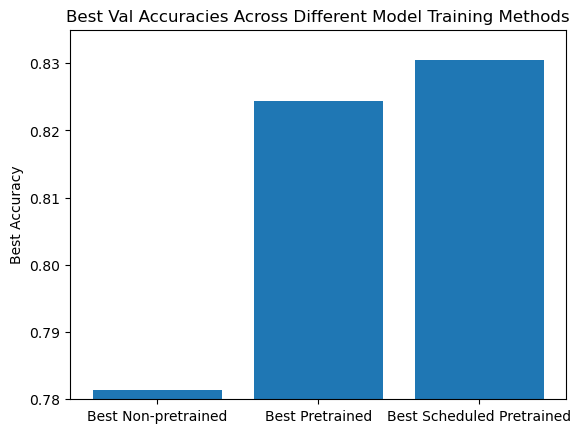

In [7]:
# visualizer of the validation phase
model = ["Best Non-pretrained", "Best Pretrained", "Best Scheduled Pretrained"]
acc = [best_non_pretrained_acc, best_pretrained_acc, best_scheduled_pretrained_acc]

plt.bar(model, acc)
plt.ylabel("Best Accuracy")
plt.title("Best Val Accuracies Across Different Model Training Methods")
plt.ylim(0.78, 0.835)
plt.show()


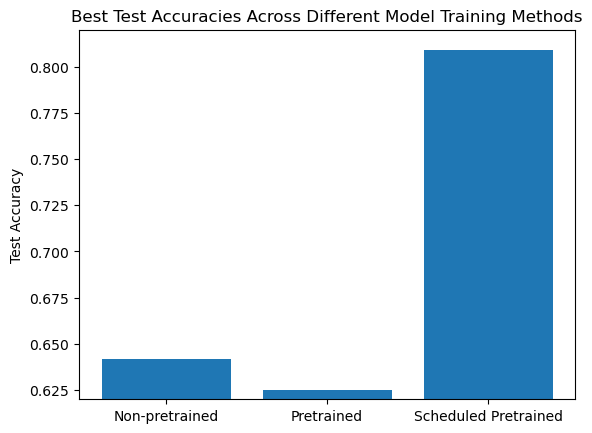

In [19]:
# visualizer of the test phase
model = ["Non-pretrained", "Pretrained", "Scheduled Pretrained"]
acc = [non_pretrained_accuracies, pretrained_accuracies, pretrained_sched_accuracies]

plt.bar(model, acc)
plt.ylabel("Test Accuracy")
plt.title("Best Test Accuracies Across Different Model Training Methods")
plt.ylim(0.62, 0.82)
plt.show()

okAAAAAAY let's move on to adversarial training now that we've seen that transfer learning improves accuracy. These are the adversarial transformation functions.

In [37]:
def fgsm_attack(model, images, labels, epsilon):
    # Ensure we're working with a fresh tensor that tracks gradients
    images = images.clone().detach().requires_grad_(True)
    labels = labels.float()  # BCEWithLogitsLoss expects float labels

    # Forward pass
    outputs = model(images)
    loss = nn.BCEWithLogitsLoss()(outputs, labels)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Get gradient and create adversarial image
    grad = images.grad.detach()
    adv_images = images + epsilon * grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images

def bim_attack(model, images, labels, epsilon, alpha, iters):
    model.eval()
    labels = labels.float()  # for BCEWithLogitsLoss
    original = images.clone().detach()
    images = original.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(images)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Update with sign of gradient
        grad = images.grad.detach()
        images = images + alpha * grad.sign()

        # Project perturbation to epsilon-ball and clamp to valid pixel range
        eta = torch.clamp(images - original, min=-epsilon, max=epsilon)
        images = torch.clamp(original + eta, 0, 1).detach().requires_grad_(True)

    return images.detach()

def pgd_attack(model, images, labels, epsilon, alpha, iters):
    model.eval()
    labels = labels.float()
    original = images.clone().detach()
    perturbed = original.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(perturbed)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = perturbed.grad.detach()
        perturbed = perturbed + alpha * grad.sign()

        # Project to epsilon ball and clamp
        perturbation = torch.clamp(perturbed - original, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(original + perturbation, 0, 1).detach().requires_grad_(True)

    return perturbed.detach()


In [38]:
# to make the new adversarial NIH datasets
def generate_adversarial_dataset(model, loader, attack_fn, **kwargs):
    model.eval()
    adv_images_list, labels_list = [], []
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = attack_fn(model, images, labels, **kwargs)
        adv_images_list.append(adv_images.detach().cpu())
        labels_list.append(labels.cpu())
    return torch.utils.data.TensorDataset(torch.cat(adv_images_list), torch.cat(labels_list))

Let's augment the NIH dataset to use it as adversarial data.

In [39]:
from torchvision.models import ResNet18_Weights

# 1. Rebuild the model architecture
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(UNIFIED_LABELS))
model_ft = model_ft.to(device)

# 2. Load weights
model_ft.load_state_dict(torch.load('/shared/home/jea040/Final_Project/notebooks/nih_model_pretrained_scheduled.pt'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
print(f"Train dataset size: {len(train_loader.dataset)}")

label_sum = torch.zeros(len(UNIFIED_LABELS))

for _, label in train_loader.dataset:
    label_sum += label

print("Label counts:", label_sum.int().tolist())

Train dataset size: 39101
Label counts: [9220, 2220, 10622, 15882, 5085, 3697, 2705, 4032]


In [ ]:
#### DO NOT RUN AGAIN!!!
class IndexedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        return x, y, idx  # returns image, label, and index


indexed_train_loader = DataLoader(
    IndexedDataset(train_dataset),  # your original train_dataset
    batch_size=32,
    shuffle=False
)

adv_train_fgsm = generate_adversarial_dataset(model_ft, train_loader, fgsm_attack, epsilon=0.03)
print("fgsm done")
adv_train_bim  = generate_adversarial_dataset(model_ft, train_loader, bim_attack,  epsilon=0.03, alpha=0.005, iters=10)
print("bim done")
adv_train_pgd  = generate_adversarial_dataset(model_ft, train_loader, pgd_attack,  epsilon=0.03, alpha=0.005, iters=10)
print("pdg done")

In [ ]:
# save datasets
torch.save(adv_train_fgsm, 'adv_train_fgsm.pt')
torch.save(adv_train_bim,  'adv_train_bim.pt')
torch.save(adv_train_pgd,  'adv_train_pgd.pt')

Okay let's train the model on the adv datasets. First let's prep the saved datasets.

In [5]:
# Load adversarial datasets
adv_train_fgsm = torch.load("adv_train_fgsm.pt")
adv_train_bim  = torch.load("adv_train_bim.pt")
adv_train_pgd  = torch.load("adv_train_pgd.pt")


In [6]:
# Create DataLoaders
batch_size = 32
adv_loaders = {
    'fgsm': DataLoader(adv_train_fgsm, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'bim':  DataLoader(adv_train_bim, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'pgd':  DataLoader(adv_train_pgd, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}
print("dataloading done")


dataloading done


Train the pretrained + scheduler model on the adversarial datasets.

In [61]:
import shutil

# Copy model to /tmp for faster loading
shutil.copy(
    "/shared/home/jea040/Final_Project/notebooks/nih_model_pretrained_scheduled.pt",
    "/tmp/nih_model.pt"
)

# Define model loading function
def load_scheduled_pretrained_model(path):
    print(f"⏳ Loading model from: {path}")
    start = time.time()
    
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 8)  # adjust output layer
    state_dict = torch.load(path, map_location='cpu')  # prevent GPU load lag
    model.load_state_dict(state_dict)
    
    model = model.to(device)
    print(f"✅ Model loaded in {time.time() - start:.2f} seconds")
    return model

# Fine-tune and save for each attack type
for name, adv_loader in adv_loaders.items():
    print(f"\n🔁 Fine-tuning on {name.upper()} adversarial data")

    # Step 1: Load pretrained base model
    model_path = "/tmp/nih_model.pt"  # or use original path if not copied
    model = load_scheduled_pretrained_model(model_path)
    
    # Step 2: Define optimizer & scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = exp_lr_scheduler

    # Step 3: Fine-tune on adversarial data
    print("🚀 Training started...")
    start_train = time.time()
    
    trained_model, accs, losses = train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        lr_scheduler=scheduler,
        num_epochs=NUM_EPOCHS,
        val=False
    )
    
    print(f"✅ Training finished in {time.time() - start_train:.2f} seconds")

    # Step 4: Save fine-tuned model
    save_path = f"/shared/home/jea040/Final_Project/notebooks/model_adv_{name}_finetuned.pt"
    torch.save(trained_model.state_dict(), save_path)
    print(f"💾 Saved fine-tuned model to: {save_path}")


🔁 Fine-tuning on FGSM adversarial data
⏳ Loading model from: /tmp/nih_model.pt
✅ Model loaded in 0.22 seconds
🚀 Training started...
----------
Epoch 0/7
----------
Sample predictions (first 10): [ True False  True False False False False False]
Sample labels (first 10): [0. 0. 1. 0. 1. 0. 0. 0.]
conv1.weight grad mean: 0.002444
train Loss: 1.0198 Acc: 0.8289
val Loss: 1.0507 Acc: 0.8066
----------
Epoch 1/7
----------
train Loss: 1.0025 Acc: 0.8439
val Loss: 1.0554 Acc: 0.8123
----------
Epoch 2/7
----------
train Loss: 0.9825 Acc: 0.8623
val Loss: 1.0503 Acc: 0.8120
----------
Epoch 3/7
----------
train Loss: 0.9665 Acc: 0.8780
val Loss: 1.0516 Acc: 0.8131
----------
Epoch 4/7
----------
train Loss: 0.9510 Acc: 0.8924
val Loss: 1.0553 Acc: 0.8181
----------
Epoch 5/7
----------
train Loss: 0.9390 Acc: 0.9046
val Loss: 1.0591 Acc: 0.8224
Early stopping at epoch 5 due to no improvement in val loss for 3 epochs.
Training complete in 16m 2s
Best val Acc: 0.8120
✅ Training finished in 962

Test them.

In [62]:
model_paths = {
    'fgsm': 'model_adv_fgsm_finetuned.pt',
    'bim':  'model_adv_bim_finetuned.pt',
    'pgd':  'model_adv_pgd_finetuned.pt'
}

for name, path in model_paths.items():
    print(f"\n🔍 Loading {name.upper()} model")

    # Load state_dict
    state_dict = torch.load(path)

    # Remove incompatible fc layer (trained on 11 classes)
    state_dict.pop('fc.weight', None)
    state_dict.pop('fc.bias', None)

    # Rebuild model for 8 output classes
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 8)  # or len(UNIFIED_LABELS) if defined

    # Load compatible layers
    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)
    model.eval()

    # Evaluate (replace with your function)
    _, acc = evaluate_model(model, valspanish_loader, criterion)
    print(f"{name.upper()} valspanish accuracy: {acc:.4f}")



🔍 Loading FGSM model
val Loss: 1.4484, Acc: 0.3350
FGSM valspanish accuracy: 0.3350

🔍 Loading BIM model
val Loss: 1.4182, Acc: 0.4627
BIM valspanish accuracy: 0.4627

🔍 Loading PGD model
val Loss: 1.4274, Acc: 0.6379
PGD valspanish accuracy: 0.6379


Visualize the accuracies of the testing after adversarial training.

NIH Baseline accuracy on PadChest: 0.8119
PGD accuracy on PadChest: 0.6379
BIM accuracy on PadChest: 0.4627
FGSM accuracy on PadChest: 0.3350


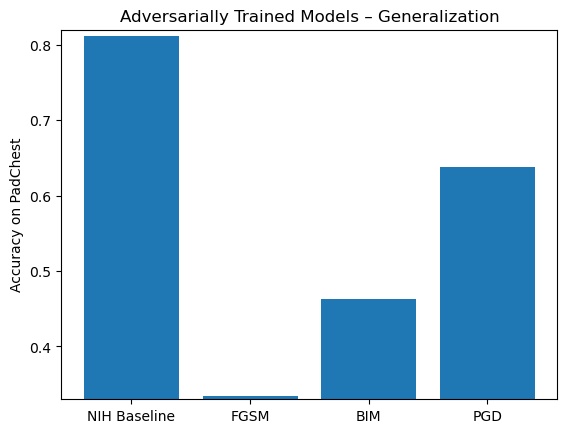

In [64]:
results = {
    "NIH Baseline": pretrained_sched_accuracies,
    "FGSM": 0.3350,
    "BIM":  0.4627,
    "PGD":  0.6379
}


# Print sorted comparison
for k, v in sorted(results.items(), key=lambda x: -x[1]):
    print(f"{k} accuracy on PadChest: {v:.4f}")

import matplotlib.pyplot as plt

names = list(results.keys())
scores = list(results.values())

plt.bar(names, scores)
plt.ylabel("Accuracy on PadChest")
plt.title("Adversarially Trained Models – Generalization")
plt.ylim(0.33, 0.82)
plt.show()


HOORAY!! First ML project, done :))